In [59]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [60]:
import matplotlib.colors as colors
import matplotlib.animation as animation
import matplotlib.ticker as mtick
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
plt.rcParams['animation.ffmpeg_path'] = r'C:\ffmpeg\bin\ffmpeg.exe'

In [61]:
import numpy as np
import scipy.special as spec
import scipy.integrate as inte
import sympy as sp
sp.init_printing()

# Position du problème

Étant donné un fil électrique très long parcouru par un courant électrique $i$, on cherche à déterminer le champ magnétique créé par phénomène d'induction dans l'espace autour. On peut le détecter en approchant une boussole, de la limaille de fer ou d'autres aimants permanents du fil, voire approcher un autre fil électrique lui aussi parcouru par un courant.

# Construction du champ magnétique

Les cellules suivantes servent à construire la fonction $B$ correspondant à l'intensité du champ magnétique $\mathbf{B}$ à une distance $r$ du fil, à l'instant $t$.

In [128]:
r, omega = sp.symbols('r omega', positive = True) # Distance et fréquence
t, phi = sp.symbols('t phi', real=True) # Temps et phase
Ic = sp.symbols('I') # Courant électrique

mu = sp.symbols("mu0", positive = True) # Perméabilité magnétique du vide
c = sp.symbols("c", positive=True)      # Célérité de la lumière dans le vide
k = omega/c                             # relation de dispersion

# Composante du potentiel vecteur associée à la pulsation omega
A_component = -mu*Ic/2* \
    (sp.bessely(0,k*r) + sp.I*sp.besselj(0,k*r))*sp.exp(sp.I*(omega*t-phi))

# Composante du champ associée à la pulsation omega
B_component = -A_component.diff(r).simplify()
B_comp_real = sp.re(B_component)

# Création du champ (symbolique et fonction) en sommant les composantes
def create_Bfield(intens,puls,phas):
    # Constantes numériques à substituer
    spectr = zip(intens,puls,phas)
    c0 = 3e8
    mu0_v = 4e-7*np.pi
    
    B_field = sum([B_comp_real.subs({Ic: cur, omega:om, phi:ph, c:c0, mu:mu0_v}) \
            for (cur,om,ph) in spectr])
    
    B_function = sp.lambdify((r, t), B_field, 
        modules=['numpy',{"besselj":spec.jn, "bessely":spec.yn}])
    
    return B_field, B_function

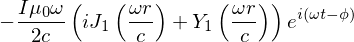

In [115]:
B_component

In [121]:
def graphe_B(times, ani = False):
    '''
    Construit les graphes du champ magnétique B aux temps donnés dans la liste
    "times"
    Si le drapeau 'ani' est True, alors entrer en mode "animation"
    '''
    radii = np.linspace(rmin, rmax, 1000)
    
    fig = plt.figure(1, figsize=(8,5), dpi=100)
    ax = plt.axes()
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
    
    def legende(ti):
        out = r'$t= {:.3e}$'.format(ti)
        out = out + r"$\ \mathrm{s}$"
        return out
        
    if not(ani):
        if hasattr(times, '__iter__'):
            for ti in times:
                champ = B_function(radii, ti)
                ax.plot(radii, champ, label=legende(ti))
        else:
            champ = B_function(radii, ti)
            ax.plot(radii, champ, label=legende(ti))
        ax.legend()
    else:
        line, = ax.plot([], [], lw=2)
        time_text = ax.text(0.02, 0.95, '', 
                            transform=ax.transAxes)
        
        
        t0, t1= times
        interval = t1 - t0
        animtime = 15
        fps = 30
        dt = interval/animtime # secondes vidéo par seconde réelle
        framenum = int(np.ceil(fps*animtime))
        
        ymax = B_function(radii,t0).max()
        
        ax.set_xlim(0,rmax)
        ax.set_ylim((-ymax/2,ymax))
        
        def init():
            line.set_data([],[])
            time_text.set_text('')
            return line, time_text
        
        def animate(i):
            ti = dt*i+t0
            legende_temps = legende(ti)
            champ = B_function(radii, ti)
            line.set_data(radii, champ)
            time_text.set_text(legende_temps)
            return line, time_text
        
    ax.grid(True)
    ax.set_xlabel("Distance $r$ (m)")
    ax.set_ylabel("Valeur du champ (T)")
    ax.set_title(r'Champ magnétique ' + r'$\mathbf{B}$' \
                 + ' créé par un courant variable')
    
    fig.tight_layout()
    
    if ani:
        anima = animation.FuncAnimation(fig, animate, init_func=init,
                    frames = framenum, interval = interval, blit = True)
        mywriter = animation.FFMpegWriter(fps=fps, bitrate=1000)
        anima.save('champ_mag_anim.mp4', writer=mywriter)
    else:
        fig.savefig('profil_champmag.pdf')
        fig.savefig('profil_champmag.png')
        return fig, ax



In [122]:
def build_field(t, colmap='bone'):
    """
    Portrait du champ magnétique à l'instant t
    """
    wind = rmax
    
    def field_func(x,y):
        r = np.sqrt(x*x+y*y)
        Btheta = B_function(r, t)
        direct = np.array([-y/r, x/r])
        return Btheta*direct
    
    Y, X = np.ogrid[-wind:wind:1000j, -wind:wind:1000j]
    BX, BY = field_func(X, Y)
    intensity = np.sqrt(BX**2+BY**2)
    
    
    fig, ax = plt.subplots(1, 1, figsize=(8,8))
   
    heat = ax.imshow(intensity, 
                     cmap=colmap,
                     norm=colors.LogNorm(), 
                     extent=[-wind, wind, -wind, wind], 
                     alpha=0.6)
    cbar = fig.colorbar(heat,
                label='Intensité du champ (T)')
    
    strm = ax.streamplot(X,Y, BX, BY, 
        arrowstyle='->', 
        color='w',
        linewidth=0.8,
        arrowsize=2,
        density=1.4,
        )
    
    ax.grid(False)
    ax.set_aspect('equal')
    ax.set_xlim((-wind,wind))
    ax.set_ylim((-wind,wind))
    title_text = r'Champ magnétique $\mathbf{B}$ à '
    title_text += r"$t={:g}$".format(t)
    title_text += r" $\mathrm{s}$"
    ax.set_title(title_text)
    fig.tight_layout()
    
    return fig
    

# Tracés

## Données initiales

Entrez dans la variable `freqs` les fréquences du courant voulu, et dans `phas` les phases associées, et exécutez la cellule (`Ctrl + Entrée` sur le clavier) pour définir la fonction de champ :

In [156]:
def gaussienne(tau,t):
    return np.exp(-t*t/(2*tau*tau))

In [153]:
freqs = [n*1e8 for n in range(5,7)] + \
    [n*1e3 for n in range(2,5)]

puls = 2*np.pi*np.asarray(freqs) # Pulsations associées

tau = 1e-11 # durée impulsion ultrabrève type laser femtoseconde
intens = 10*gaussienne(tau,puls) # Intensités des composantes

phases = [0,0,0,0,0] # Phases des composantes

B_field, B_function = create_Bfield(intens, puls, phases)

In [152]:
B_function(0.3,1e-9)

In [150]:
B_field

La cellule suivante définit les distances minimale et maximale pour lesquels tracer le profil du champ magnétique :

In [67]:
rmin = 0.03
rmax = 2

(<matplotlib.figure.Figure at 0x65d7240>,
 <matplotlib.axes._subplots.AxesSubplot at 0x937aef0>)

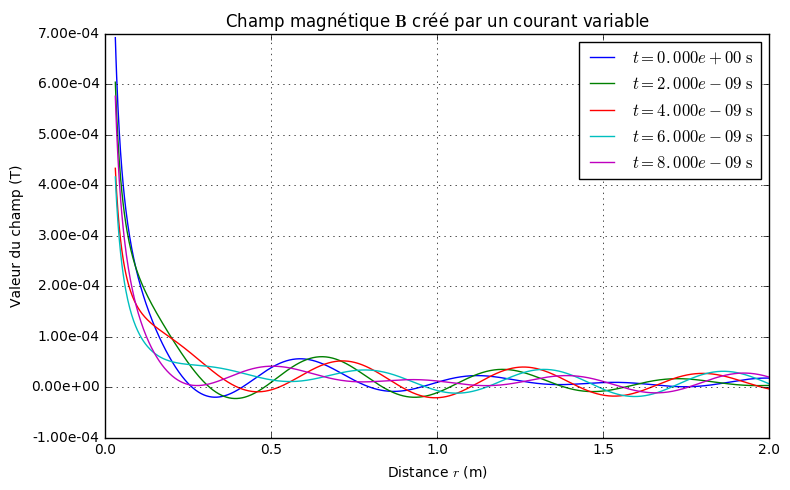

In [155]:
times = [1e-9*k for k in [0, 2, 4, 6, 8]]

graphe_B(times)

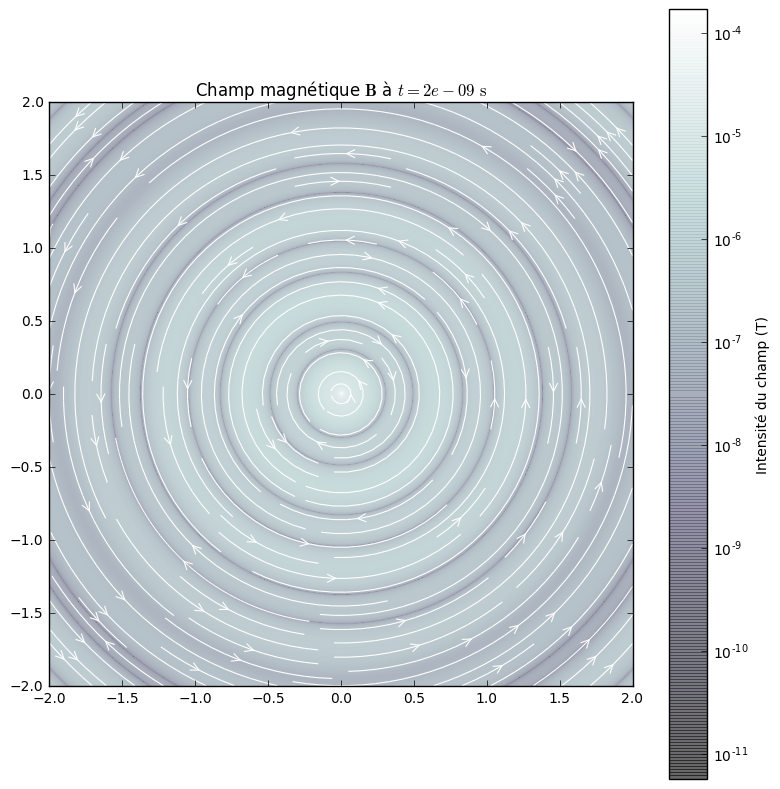

In [116]:
t = times[2]    # Temps auquel calculer le portrait du champ (pas de liste)

field_lines = build_field(t)
field_lines.savefig('portrait_champmag.pdf')
field_lines.savefig('portrait_champmag.png')

## Animations

Modifiez cette cellule avec les fréquences que vous voulez utiliser pour les animations :

In [130]:
freqs = [n*1e8 for n in range(5,7)] + \
    [n*1e7 for n in range(2,5)]
puls = 2*np.pi*np.asarray(freqs) # Pulsations associées

phases = [0,0,0.7,0.8,0.3]

B_field, B_function = create_Bfield(puls, phases)

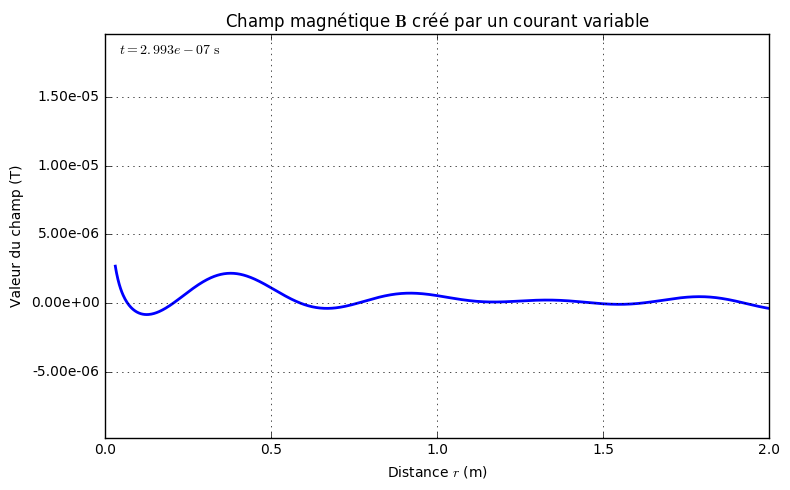

In [131]:
times_an = [0, 1e-8]

graphe_B(times_an, True)

# Théorie (Bac + 1,5)

Le champ magnétique $\mathbf{B}$ dérive d'un champ $\mathbf A$ appelé *potentiel vecteur* : $\mathbf{B} = \boldsymbol\nabla\wedge\mathbf{A}$. Par symétrie cylindrique, on a $\mathbf{B}(\mathbf r, t) = B(r,t)\mathbf{e}_\theta$. Par suite $\mathbf A(\mathbf r,t) = A(r,t)\mathbf e_z$.

Le potentiel vecteur $\mathbf{A} = A(r,t)\mathbf{e}_z$ est solution de l'équation d'onde

\begin{equation}
\Delta\mathbf A  - \frac{1}{c^2}\frac{\partial^2\mathbf A}{\partial t^2} = - \mu_0\mathbf{J}(r,t),
\end{equation}

avec $\mathbf J(r,t)  = \dfrac{i(t)\delta(r)}{2\pi r}\mathbf{e}_z$ la densité volumique de courant.


Pour un courant sinusoïdal $i(t) = I\exp(i\omega t)$, le potentiel s'écrit $A(r,t) = f(r)\exp(i\omega t)$ et l'équation aux dérivées partielles se réduit à

\begin{equation}
\frac{1}{r}\frac{\mathrm d}{\mathrm dr}\left(r\frac{\mathrm df}{\mathrm dr} \right) + k^2f(r) = -\frac{\mu_0I\delta(r)}{2\pi r},
\end{equation}

avec $k=\dfrac{\omega}{c}$.

La solution générale prend la forme

$$
f(r) = CJ_0(kr) + DY_0(kr)
$$

où $C$ et $D$ dépendent de la pulsation $\omega$ du courant, et $J_0,Y_0$ sont les 0-ièmes fonctions de Bessel de la première et seconde espèce, solutions de $$xy''(x) + y'(x) + xy(x) = 0.$$